# A simple open-domain summarization pipeline

## Build a local in-memory index and index some relevant documents

In [1]:
from haystack import Document, Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.components.rankers import TransformersSimilarityRanker
from haystack.components.generators import HuggingFaceLocalGenerator
from haystack.components.builders.prompt_builder import PromptBuilder

/home/user/fastRAG/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
examples = [
    "Lionel Andrés Messi[note 1] (Spanish pronunciation: [ljoˈnel anˈdɾes ˈmesi] (listen); born 24 June 1987), also known as Leo Messi, is an Argentine professional footballer who plays as a forward for Ligue 1 club Paris Saint-Germain and captains the Argentina national team. Widely regarded as one of the greatest players of all time, Messi has won a record seven Ballon d'Or awards,[note 2] a record six European Golden Shoes, and in 2020 was named to the Ballon d'Or Dream Team. Until leaving the club in 2021, he had spent his entire professional career with Barcelona, where he won a club-record 35 trophies, including 10 La Liga titles, seven Copa del Rey titles and four UEFA Champions Leagues. With his country, he won the 2021 Copa América and the 2022 FIFA World Cup. A prolific goalscorer and creative playmaker, Messi holds the records for most goals in La Liga (474), most hat-tricks in La Liga (36) and the UEFA Champions League (8), and most assists in La Liga (192) and the Copa América (17). He has also the most international goals by a South American male (98). Messi has scored over 795 senior career goals for club and country, and has the most goals by a player for a single club (672).",
    "Born and raised in central Argentina, Messi relocated to Spain at the age of 13 to join Barcelona, for whom he made his competitive debut aged 17 in October 2004. He established himself as an integral player for the club within the next three years, and in his first uninterrupted season in 2008–09 he helped Barcelona achieve the first treble in Spanish football; that year, aged 22, Messi won his first Ballon d'Or. Three successful seasons followed, with Messi winning four consecutive Ballons d'Or, making him the first player to win the award four times. During the 2011–12 season, he set the La Liga and European records for most goals scored in a single season, while establishing himself as Barcelona's all-time top scorer. The following two seasons, Messi finished second for the Ballon d'Or behind Cristiano Ronaldo (his perceived career rival), before regaining his best form during the 2014–15 campaign, becoming the all-time top scorer in La Liga and leading Barcelona to a historic second treble, after which he was awarded a fifth Ballon d'Or in 2015. Messi assumed captaincy of Barcelona in 2018, and in 2019 he won a record sixth Ballon d'Or. Out of contract, he signed for Paris Saint-Germain in August 2021.",
    "An Argentine international, Messi holds the national record for appearances and is also the country's all-time leading goalscorer. At youth level, he won the 2005 FIFA World Youth Championship, finishing the tournament with both the Golden Ball and Golden Shoe, and an Olympic gold medal at the 2008 Summer Olympics. His style of play as a diminutive, left-footed dribbler drew comparisons with his compatriot Diego Maradona, who described Messi as his successor. After his senior debut in August 2005, Messi became the youngest Argentine to play and score in a FIFA World Cup in 2006, and reached the final of the 2007 Copa América, where he was named young player of the tournament. As the squad's captain from August 2011, he led Argentina to three consecutive finals: the 2014 FIFA World Cup, for which he won the Golden Ball, and the 2015 and 2016 Copa América, winning the Golden Ball in the 2015 edition. After announcing his international retirement in 2016, he reversed his decision and led his country to qualification for the 2018 FIFA World Cup, a third-place finish at the 2019 Copa América, and victory in the 2021 Copa América, while winning the Golden Ball and Golden Boot for the latter. This achievement would see him receive a record seventh Ballon d'Or in 2021. In 2022, he captained his country to win the 2022 FIFA World Cup, for which he won the Golden Ball for a record second time, and broke the record for most appearances in World Cup tournaments with 26 matches played.",
    "Messi has endorsed sportswear company Adidas since 2006. According to France Football, he was the world's highest-paid footballer for five years out of six between 2009 and 2014, and was ranked the world's highest-paid athlete by Forbes in 2019 and 2022. Messi was among Time's 100 most influential people in the world in 2011 and 2012. In February 2020, he was awarded the Laureus World Sportsman of the Year, thus becoming the first footballer and the first team sport athlete to win the award. Later that year, Messi became the second footballer and second team-sport athlete to surpass $1 billion in career earnings."]

In [3]:
store = InMemoryDocumentStore()

In [4]:
documents = [Document(content=s) for s in examples]

In [5]:
store.write_documents(documents)

4

## Initialize the pipeline components

Initialize the components we are going to use in our pipeline.
Mainly, retriever, re-ranker and a generator capable of summarizing information (`philschmid/bart-large-cnn-samsum`).

In [6]:
retriever = InMemoryBM25Retriever(
    document_store= store,
    top_k= 10
)    
reranker = TransformersSimilarityRanker(
    model="cross-encoder/ms-marco-MiniLM-L-6-v2",
    top_k=4,
)

In [7]:
prompt = """\
{% for doc in documents %}
    {{ doc.content }}
{% endfor %}"""

In [8]:
generator = HuggingFaceLocalGenerator("philschmid/bart-large-cnn-samsum", 
                                      task="text2text-generation",
                                      generation_kwargs={"max_new_tokens": 200, 
                                                         "num_beams": 1,
                                                         "early_stopping": True,
                                                         "num_return_sequences": 1,})

In [9]:
generator.warm_up()

## Create a pipeline

In [10]:
pipe = Pipeline()

### Add the components in the right order

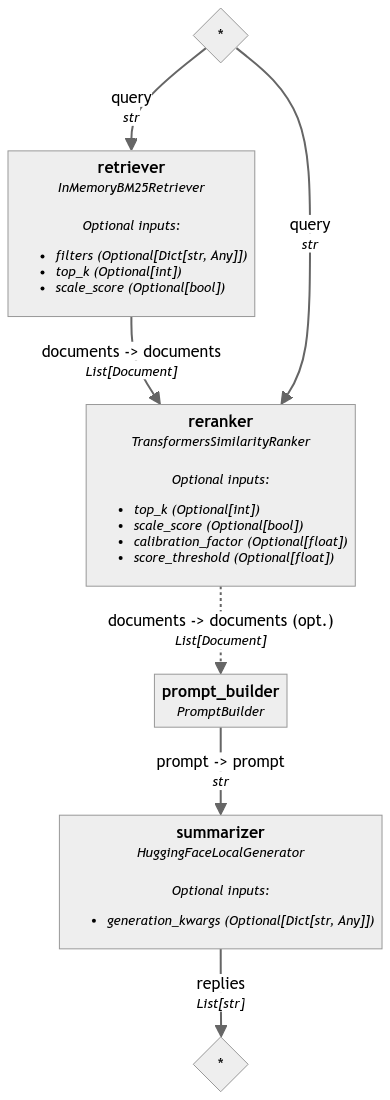

In [11]:
pipe.add_component("retriever", retriever)
pipe.add_component("reranker", reranker)
pipe.add_component("prompt_builder", PromptBuilder(template=prompt))
pipe.add_component("summarizer", generator)

pipe.connect("retriever", "reranker.documents")
pipe.connect("reranker", "prompt_builder.documents")
pipe.connect("prompt_builder", "summarizer")

### Run a query through the pipeline

In [12]:
query="Leo Messi"

In [ ]:
result = pipe.run(
    {
        "retriever": {"query": query},
        "reranker": {"query": query},
    }
)

In [14]:
print(result["summarizer"]["replies"][0])

 in 2018. He has won seven Ballon d'Or awards. He won the 2008 UEFA Champions League. He is the most decorated player in La Liga. He captained Argentina to three consecutive finals. He was named to the 2020 Ballon D'Or Dream Team. He played for Barcelona from 2004 to 2021. He moved to Paris Saint-Germain in 2011.
